In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import warnings
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

sys.path.append("/home/wangrr/Analysis/epiRNA/src")
workdir = "/data/wangrr/Analysis/epiRNA/workdir2/benchmark"
os.makedirs(workdir, exist_ok=True); os.chdir(workdir)
warnings.filterwarnings("ignore", category=UserWarning)

import epiRNA as erna

In [3]:
# model config:
config = "/home/wangrr/Analysis/epiRNA/src/experiments/model_v2/configs/basic_model.yaml"

# model checkpoint:
ckpt_dir = "/data/wangrr/Analysis/epiRNA/models"
checkpoints = {
    "complete": f"{ckpt_dir}/basic_fold/version_0/checkpoints/epoch=18-step=215327-val_ePCC_mixed=0.7823.ckpt",
    "maskrna": f"{ckpt_dir}/v2maskrna/version_0/checkpoints/epoch=11-step=135996-val_ePCC_mixed=0.4895.ckpt",
    "maskseq": f"{ckpt_dir}/v2maskseq/version_0/checkpoints/epoch=02-step=33999-val_ePCC_mixed=0.4829.ckpt",
    "maskrbp": f"{ckpt_dir}/v2maskrbp/version_0/checkpoints/epoch=10-step=124663-val_ePCC_mixed=0.6686.ckpt"
}

# load models
model_zoo = {}
for key, ckpt in checkpoints.items():
    model = erna.evals.load_model(ckpt, config)
    model.eval()
    model_zoo[key] = model

In [4]:
datainfo = pd.read_excel("/home/wangrr/Analysis/epiRNA/data/mRNA_multiomic_sample_info.xlsx", sheet_name="m6A")

samples = ["Adipose-1", "Aorta-1", "Appendix-1", "Esophagus-1", "GOS-1", "Hela-1", "HT29-1", "Hypothalamus-1", "Jejunum-1", "Liver-1", "Prostate-1", "Skin-1", "Testis-1", "Tongue-1", "Trachea-1", "WPMY-1", "MT4-1", "GSC11-1", "iSLK-1", "TIME-1", "mHeart-1", "mSpleen-1", "mLung-1", "mLiver-1", "mCerebrum-1", "mCerebellum-1", "mBrainstem-1", "mHypothalamus-1", "mBMDC-1", "mEF-1", "mNPC-1", "mESC-1", "mStriatum-1", "mPeritoneal_macrophages-1", "mB16-OVA-1", "miPSC-1", "mNSC-1", "mForebrain-1", "mKidney-1", "mHypothalamus-2"]

datainfo = datainfo[datainfo["SID"].isin(samples)].reset_index(drop=True)
ref_dir = "/data/wangrr/Analysis/epiRNA/Dataset/Reference"
genome = {
    "human":{
        "fasta": f"{ref_dir}/Homo_sapiens.GRCh38.dna.primary_assembly.84.fa",
        "gtf": f"{ref_dir}/Homo_sapiens.GRCh38.84.gtf"
    },
    "mouse":{
        "fasta": f"{ref_dir}//Mus_musculus.GRCm38.dna.primary_assembly.84.fa",
        "gtf": f"{ref_dir}/Mus_musculus.GRCm38.84.gtf"
    }
}
human_gtf_df = erna.pp.GTFLoader(gtf_path=genome["human"]["gtf"], zero_based=True)
mouse_gtf_df = erna.pp.GTFLoader(gtf_path=genome["mouse"]["gtf"], zero_based=True)

chrom_kwargs = {
    'human': {
        'train_chroms': ["1", "2", "3", "4", "5", "6", "7", "9", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22"],
        'val_chroms': ["8"],
        'test_chroms': ["10"]
    },
    'mouse': {
        'train_chroms': ["1", "2", "3", "4", "5", "6", "7", "9", "11", "12", "13", "14", "15", "16", "17", "18", "19"],
        'val_chroms': ["8"],
        'test_chroms': ["10"]
    }
}

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']


In [7]:
import pickle
with open("/home/wangrr/Analysis/epiRNA/data/rbp_expression_dict.pkl", "rb") as f:
    rbp_dict = pickle.load(f)['rbp_dict']
    
with open("/home/wangrr/Analysis/epiRNA/data/rbp_expression_dict_zero.pkl", "rb") as f:
    rbp_dict_zero = pickle.load(f)['rbp_dict']
    
bigwig_dir = "/data/wangrr/Analysis/epiRNA/Dataset/processed/4-coverage"

In [6]:
human_fasta_loader = erna.pp.FastaLoader(genome["human"]["fasta"])
mouse_fasta_loader = erna.pp.FastaLoader(genome["mouse"]["fasta"])

mouse_generator = erna.pp.DataGenerator(
    fasta_loader=mouse_fasta_loader,
    gtf_df=mouse_gtf_df,
    seq_len=65536,
    bin_size=64
)

human_generator = erna.pp.DataGenerator(
    fasta_loader=human_fasta_loader,
    gtf_df=human_gtf_df,
    seq_len=65536,
    bin_size=64
)

In [ ]:
# help function to get prediction from given sample-gene pairs using given model
def get_predictions(model, sample, gene, rbp_dict, mask_type, device="cuda:0"):
    sample_info = datainfo[datainfo["SID"]==sample].iloc[0]
    species = sample_info["Species"]
    rbp_exp = rbp_dict[sample]
    
    generator = human_generator if species=="Human" else mouse_generator
    gtf_df = human_gtf_df if species=="Human" else mouse_gtf_df
    
    gene_row = gtf_df[gtf_df["gene_name"]==gene].iloc[0]
    input_bw = erna.pp.BigWigLoader(os.path.join(bigwig_dir, "m6A", "Input", f"{sample}.bigwig"))
    ip_bw = erna.pp.BigWigLoader(os.path.join(bigwig_dir, "m6A", "IP", f"{sample}.bigwig"))
    data = generator.generate(
        gtf_row=gene_row,
        input_bwloader=input_bw,
        ip_bwloader=ip_bw,
        return_bin_input=True,
        mask_type=mask_type
    )
    
    head = 0 if species=="Human" else 1
    
    input_x = torch.tensor(data["input"]).unsqueeze(0).to(device, dtype=torch.float32)
    head_idx = torch.tensor(head).unsqueeze(0).to(device, dtype=torch.long)
    rbp_x = torch.tensor(rbp_exp).unsqueeze(0).to(device, dtype=torch.float32)
    with torch.no_grad():
        preds, attns = model(input_x, rbp_x, head_idx)
        
    preds = preds.squeeze(0).cpu()
    pcc_rna_ip = erna.nn.safe_pearson_corrcoef(
        torch.from_numpy(data["bin_input"]),
        torch.from_numpy(data["target"])
    )
    pcc_pred_ip = erna.nn.safe_pearson_corrcoef(
        torch.from_numpy(data["target"]),
        preds
    )
    loss_rna_ip = nn.MSELoss()(torch.from_numpy(data["bin_input"]), torch.from_numpy(data["target"])).item()
    loss_pred_ip = nn.MSELoss()(torch.from_numpy(data["target"]), preds).item()
    return {
        "gene": gene,
        "chrom": data['region']['chrom'],
        "strand": gene_row['strand'],
        "requested_start": data['region']['requested_start'],
        "requested_end": data['region']['requested_end'],
        "species": species,
        "sample": sample,
        "preds": preds.numpy(),
        "bin_input": data["bin_input"],
        "target": data["target"],
        "pcc_rna_ip": pcc_rna_ip,
        "pcc_pred_ip": pcc_pred_ip,
        "loss_rna_ip": loss_rna_ip,
        "loss_pred_ip": loss_pred_ip
    }
    

In [137]:
model_zoo.keys()

dict_keys(['complete', 'maskrna', 'maskseq', 'maskrbp'])

In [138]:
sample = "Hela-1"
gene = "YTHDF3"

In [139]:
out = get_predictions(
    model_zoo['complete'].cuda(), 
    sample=sample, 
    gene=gene, 
    rbp_dict=rbp_dict, 
    mask_type=None, 
    device="cuda"
)


In [140]:
out

{'gene': 'YTHDF3',
 'chrom': '8',
 'strand': '+',
 'requested_start': 63157901,
 'requested_end': 63223437,
 'species': 'Human',
 'sample': 'Hela-1',
 'preds': array([0.08316708, 0.08012377, 0.05831315, ..., 0.04029831, 0.0199465 ,
        0.01195521], dtype=float32),
 'bin_input': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'target': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'pcc_rna_ip': tensor(0.7287),
 'pcc_pred_ip': tensor(0.9466),
 'loss_rna_ip': 0.3738343119621277,
 'loss_pred_ip': 0.07634252309799194}

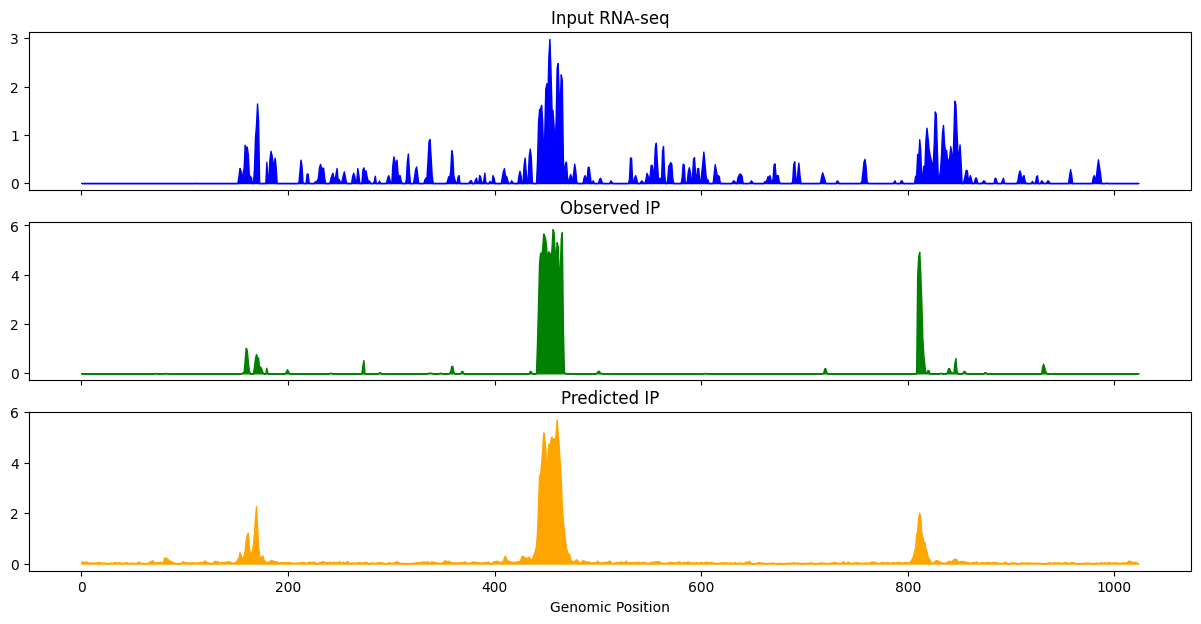

In [141]:
erna.pl.multiple_tracks_plot(
    input_obs=out['bin_input'],
    ip_obs=out['target'],
    ip_pred=out['preds'],
    actmap=None,
    figsize=(15,7)
)

In [142]:
maskrna_out = get_predictions(
    model_zoo['maskrna'].cuda(), 
    sample=sample, 
    gene=gene, 
    rbp_dict=rbp_dict, 
    mask_type="expression", 
    device="cuda"
)
maskrna_out

{'gene': 'YTHDF3',
 'chrom': '8',
 'strand': '+',
 'requested_start': 63157901,
 'requested_end': 63223437,
 'species': 'Human',
 'sample': 'Hela-1',
 'preds': array([0.01667499, 0.01454091, 0.01842532, ..., 0.00507797, 0.01337019,
        0.01452298], dtype=float32),
 'bin_input': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'target': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'pcc_rna_ip': tensor(0.),
 'pcc_pred_ip': tensor(0.7836),
 'loss_rna_ip': 0.6864330768585205,
 'loss_pred_ip': 0.4232989549636841}

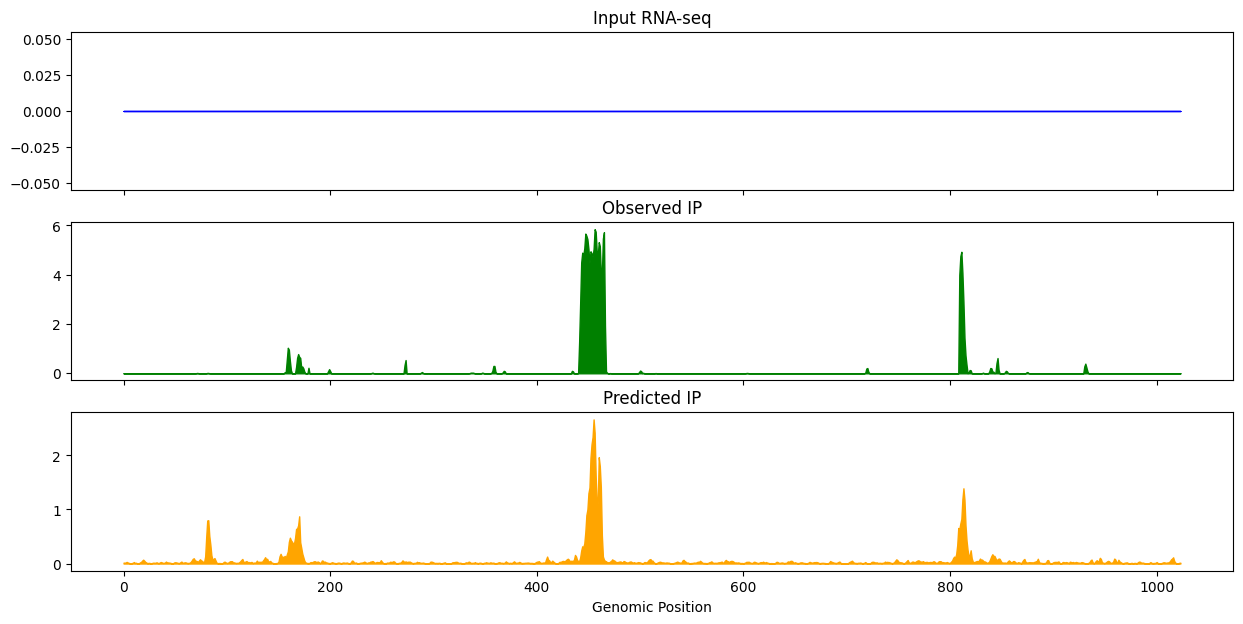

In [143]:
erna.pl.multiple_tracks_plot(
    input_obs=maskrna_out['bin_input'],
    ip_obs=maskrna_out['target'],
    ip_pred=maskrna_out['preds'],
    actmap=None,
    figsize=(15,7)
)

In [144]:
maskseq_out = get_predictions(
    model_zoo['maskseq'].cuda(), 
    sample=sample, 
    gene=gene, 
    rbp_dict=rbp_dict, 
    mask_type="sequence", 
    device="cuda"
)
maskseq_out

{'gene': 'YTHDF3',
 'chrom': '8',
 'strand': '+',
 'requested_start': 63157901,
 'requested_end': 63223437,
 'species': 'Human',
 'sample': 'Hela-1',
 'preds': array([0.15212175, 0.21620744, 0.20854351, ..., 0.23023416, 0.14978266,
        0.10140195], dtype=float32),
 'bin_input': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'target': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'pcc_rna_ip': tensor(0.7287),
 'pcc_pred_ip': tensor(0.8808),
 'loss_rna_ip': 0.3738343119621277,
 'loss_pred_ip': 0.16744831204414368}

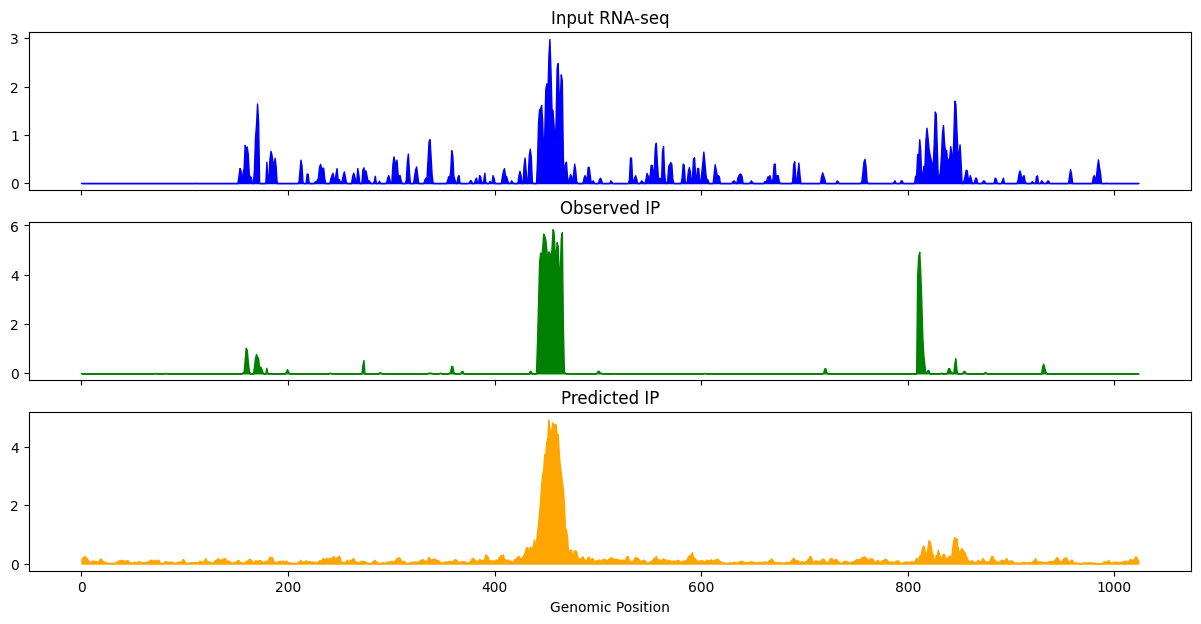

In [145]:
erna.pl.multiple_tracks_plot(
    input_obs=maskseq_out['bin_input'],
    ip_obs=maskseq_out['target'],
    ip_pred=maskseq_out['preds'],
    actmap=None,
    figsize=(15,7)
)

In [146]:
maskrbp_out = get_predictions(
    model_zoo['maskrbp'].cuda(), 
    sample=sample, 
    gene=gene, 
    rbp_dict=rbp_dict_zero, 
    mask_type=None, 
    device="cuda"
)
maskrbp_out

{'gene': 'YTHDF3',
 'chrom': '8',
 'strand': '+',
 'requested_start': 63157901,
 'requested_end': 63223437,
 'species': 'Human',
 'sample': 'Hela-1',
 'preds': array([0.07247806, 0.06613163, 0.05087065, ..., 0.03766403, 0.01981463,
        0.01162353], dtype=float32),
 'bin_input': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'target': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'pcc_rna_ip': tensor(0.7287),
 'pcc_pred_ip': tensor(0.8386),
 'loss_rna_ip': 0.3738343119621277,
 'loss_pred_ip': 0.27134624123573303}

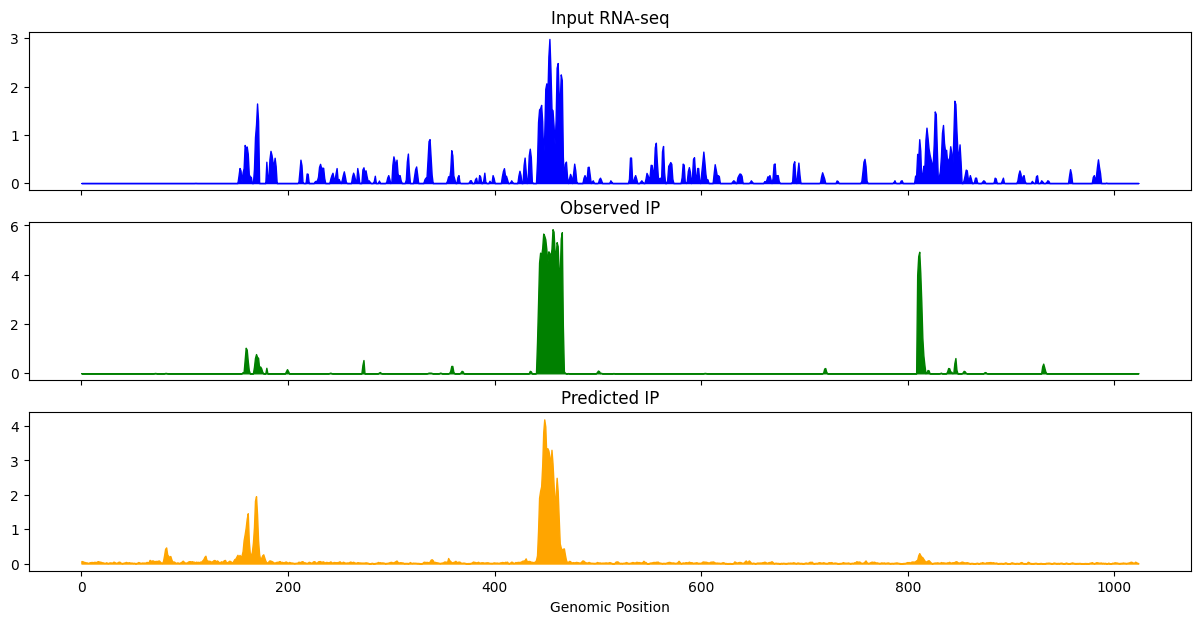

In [147]:
erna.pl.multiple_tracks_plot(
    input_obs=maskrbp_out['bin_input'],
    ip_obs=maskrbp_out['target'],
    ip_pred=maskrbp_out['preds'],
    actmap=None,
    figsize=(15,7)
)

In [148]:
all_preds = {
    "complete": out,
    "maskrna": maskrna_out,
    "maskseq": maskseq_out,
    "maskrbp": maskrbp_out
}

# save to bigwig
save_dir = "./predicted_bigwig"
os.makedirs(save_dir, exist_ok=True)
for model_name, out in all_preds.items():
    bw_path = os.path.join(save_dir, f"{sample}_{gene}_{model_name}.bigwig")
    erna.pp.bioloader.coverage_to_bigwig(
        coverage=out['preds'],
        chrom=out['chrom'],
        start=out['requested_start'],
        end=out['requested_end'],
        strand=out["strand"],
        chrom_sizes=human_fasta_loader.chr_sizes,
        output_path=bw_path
    )

bigWig file created: ./predicted_bigwig/Hela-1_YTHDF3_complete.bigwig
Total intervals: 1,024
Value range: [0.0084, 5.7183]
bigWig file created: ./predicted_bigwig/Hela-1_YTHDF3_maskrna.bigwig
Total intervals: 1,024
Value range: [0.0007, 2.6680]
bigWig file created: ./predicted_bigwig/Hela-1_YTHDF3_maskseq.bigwig
Total intervals: 1,024
Value range: [0.0084, 4.9372]
bigWig file created: ./predicted_bigwig/Hela-1_YTHDF3_maskrbp.bigwig
Total intervals: 1,024
Value range: [0.0055, 4.1934]
